# Convolutional Neural Network (CNN): MNIST

In [31]:
import struct

import warnings
warnings.simplefilter("ignore")

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

import tensorflow.keras as keras
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, EarlyStopping

In [3]:
def read_images(filename):
    with open(filename, 'rb') as f:
        # Read the header information
        magic_number, num_images, rows, cols = struct.unpack(">IIII", f.read(16))
        # Read the image data
        image_data = f.read()
        images = np.frombuffer(image_data, dtype=np.uint8).reshape(num_images, rows, cols)
    return images

def read_labels(filename):
    with open(filename, 'rb') as f:
        # Read the header information
        magic_number, num_labels = struct.unpack(">II", f.read(8))
        # Read the label data
        label_data = f.read()
        labels = np.frombuffer(label_data, dtype=np.uint8)
    return labels

# load MNIST dataset
root = '../../Datasets/MNIST/'
train_images_path = root + 'train-images-idx3-ubyte/train-images-idx3-ubyte'
train_labels_path = root + 'train-labels-idx1-ubyte/train-labels-idx1-ubyte'
test_images_path = root + 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte'
test_labels_path = root + 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte'

# read the datasets
train_X = read_images(train_images_path) #images
train_y = read_labels(train_labels_path) #labels
test_X = read_images(test_images_path)   #images
test_y = read_labels(test_labels_path)   #labels

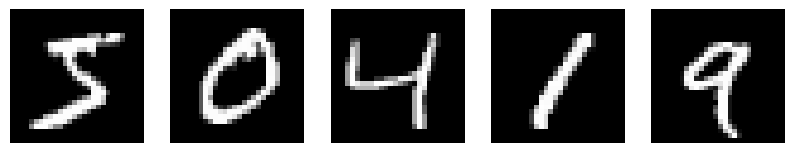

60000

10

In [4]:
# plot sample images
fig, axes = plt.subplots(1, 5, figsize=(10, 2))  
for i in range(5):
    axes[i].imshow(train_X[i].reshape(28, 28), cmap="gray")  # Reshape the 28x28 image and display it
    axes[i].axis('off')  # Hide the axes
plt.show()

# get some high-level stats
num_images, height, width = train_X.shape
num_classes = len(np.unique(train_y))
display(num_images, num_classes)

In [5]:
# copy train_X and test_X to make them writable
train_X = np.copy(train_X.reshape(train_X.shape[0], 28, 28, 1).astype('float32'))
test_X = np.copy(test_X.reshape(test_X.shape[0], 28, 28, 1).astype('float32'))

# normalisation
train_X /= 255.0
test_X /= 255.0

# one-hot encode labels
train_y = np.eye(10)[train_y]
test_y = np.eye(10)[test_y]

In [15]:
# Data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=20,      # randomly rotate images up to 10 degrees
    zoom_range=0.1,         # randomly zoom image up to 10% 
    width_shift_range=0.1,  # randomly shift images horizontally up to 10%
    height_shift_range=0.1  # randomly shift images vertically up to 10%
    # horizontal_flip=False,  # randomly flip images horizontally
    # vertical_flip=False     # randomly flip images vertically
)
datagen.fit(train_X)

In [16]:
# build model
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last', input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid' ))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu', data_format='channels_last'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='valid', strides=2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     1,606,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,213,610 (8.44 MB)

 Trainable params: 2,210,154 (8.43 MB)

 Non-trainable params: 3,456 (13.50 KB)

In [17]:
# compile model
model.compile(
    optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999), 
    loss="categorical_crossentropy", 
    metrics=["accuracy"]
)

In [18]:
# fit model
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5, # number of epochs to wait for improvement
    restore_best_weights=True # roll back to best model weights
)

history = model.fit(
    datagen.flow(train_X, train_y, batch_size=64), # only apply data augmentation on training set
    validation_data=(test_X, test_y), 
    epochs=20,
    callbacks=[early_stopping]
) 

Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 31s 30ms/step - accuracy: 0.8164 - loss: 0.6436 - val_accuracy: 0.9841 - val_loss: 0.0550
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 29s 31ms/step - accuracy: 0.9557 - loss: 0.1462 - val_accuracy: 0.9892 - val_loss: 0.0345
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 29s 31ms/step - accuracy: 0.9679 - loss: 0.1061 - val_accuracy: 0.9885 - val_loss: 0.0357
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 30s 32ms/step - accuracy: 0.9704 - loss: 0.0926 - val_accuracy: 0.9893 - val_loss: 0.0325
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 30s 32ms/step - accuracy: 0.9755 - loss: 0.0798 - val_accuracy: 0.9886 - val_loss: 0.0356
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 39s 42ms/step - accuracy: 0.9769 - loss: 0.0783 - val_accuracy: 0.9876 - val_loss: 0.0363
Epoch 7/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 28s 30ms/step - accuracy: 0.9784 - loss: 0.0725 - val_accuracy: 0.9931 - val_loss: 0.0219
Epoch 8/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 30s 32ms/step - accuracy: 0.9816 - loss: 0.0632 - 

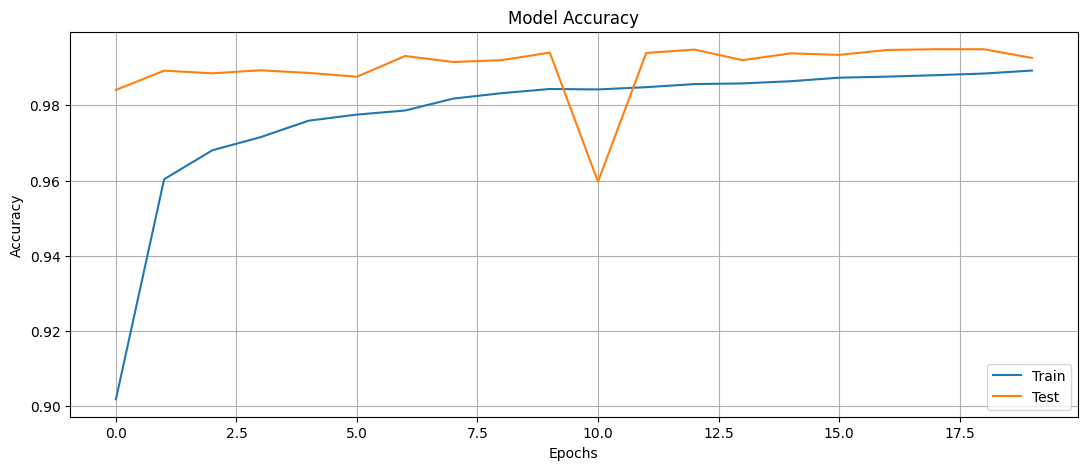

In [23]:
# evaluate model
plt.figure(figsize=(13, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.grid()
plt.show()

In [24]:
# keras.utils.plot_model(
#     model,
#     to_file="nn-cnn-mnist-model.png",
#     show_shapes=True,
#     show_dtype=False,
#     show_layer_names=False,
#     rankdir="TB",
#     expand_nested=False,
#     dpi=100,
#     show_layer_activations=True,
#     show_trainable=False
# )

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy: 0.9949
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       980
           1       1.00      0.99      1.00      1135
           2       0.99      1.00      1.00      1032
           3       0.99      1.00      0.99      1010
           4       0.99      1.00      1.00       982
           5       1.00      0.99      0.99       892
           6       1.00      1.00      1.00       958
           7       0.99      1.00      0.99      1028
           8       0.99      1.00      0.99       974
           9       1.00      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



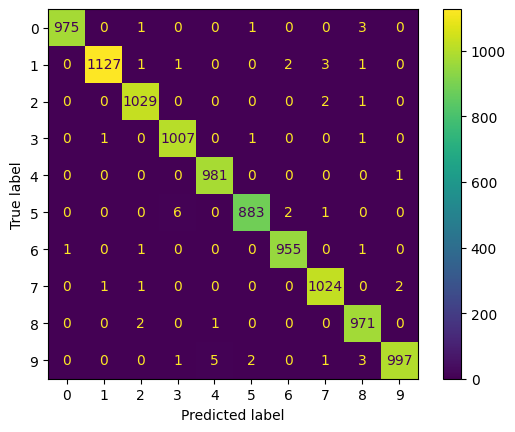

In [52]:
# evaluate
y_probs = model.predict(test_X)
y_pred = np.argmax(y_probs, axis=1)
y_true = np.argmax(test_y, axis=1)

print("Accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

Misclassified = 51


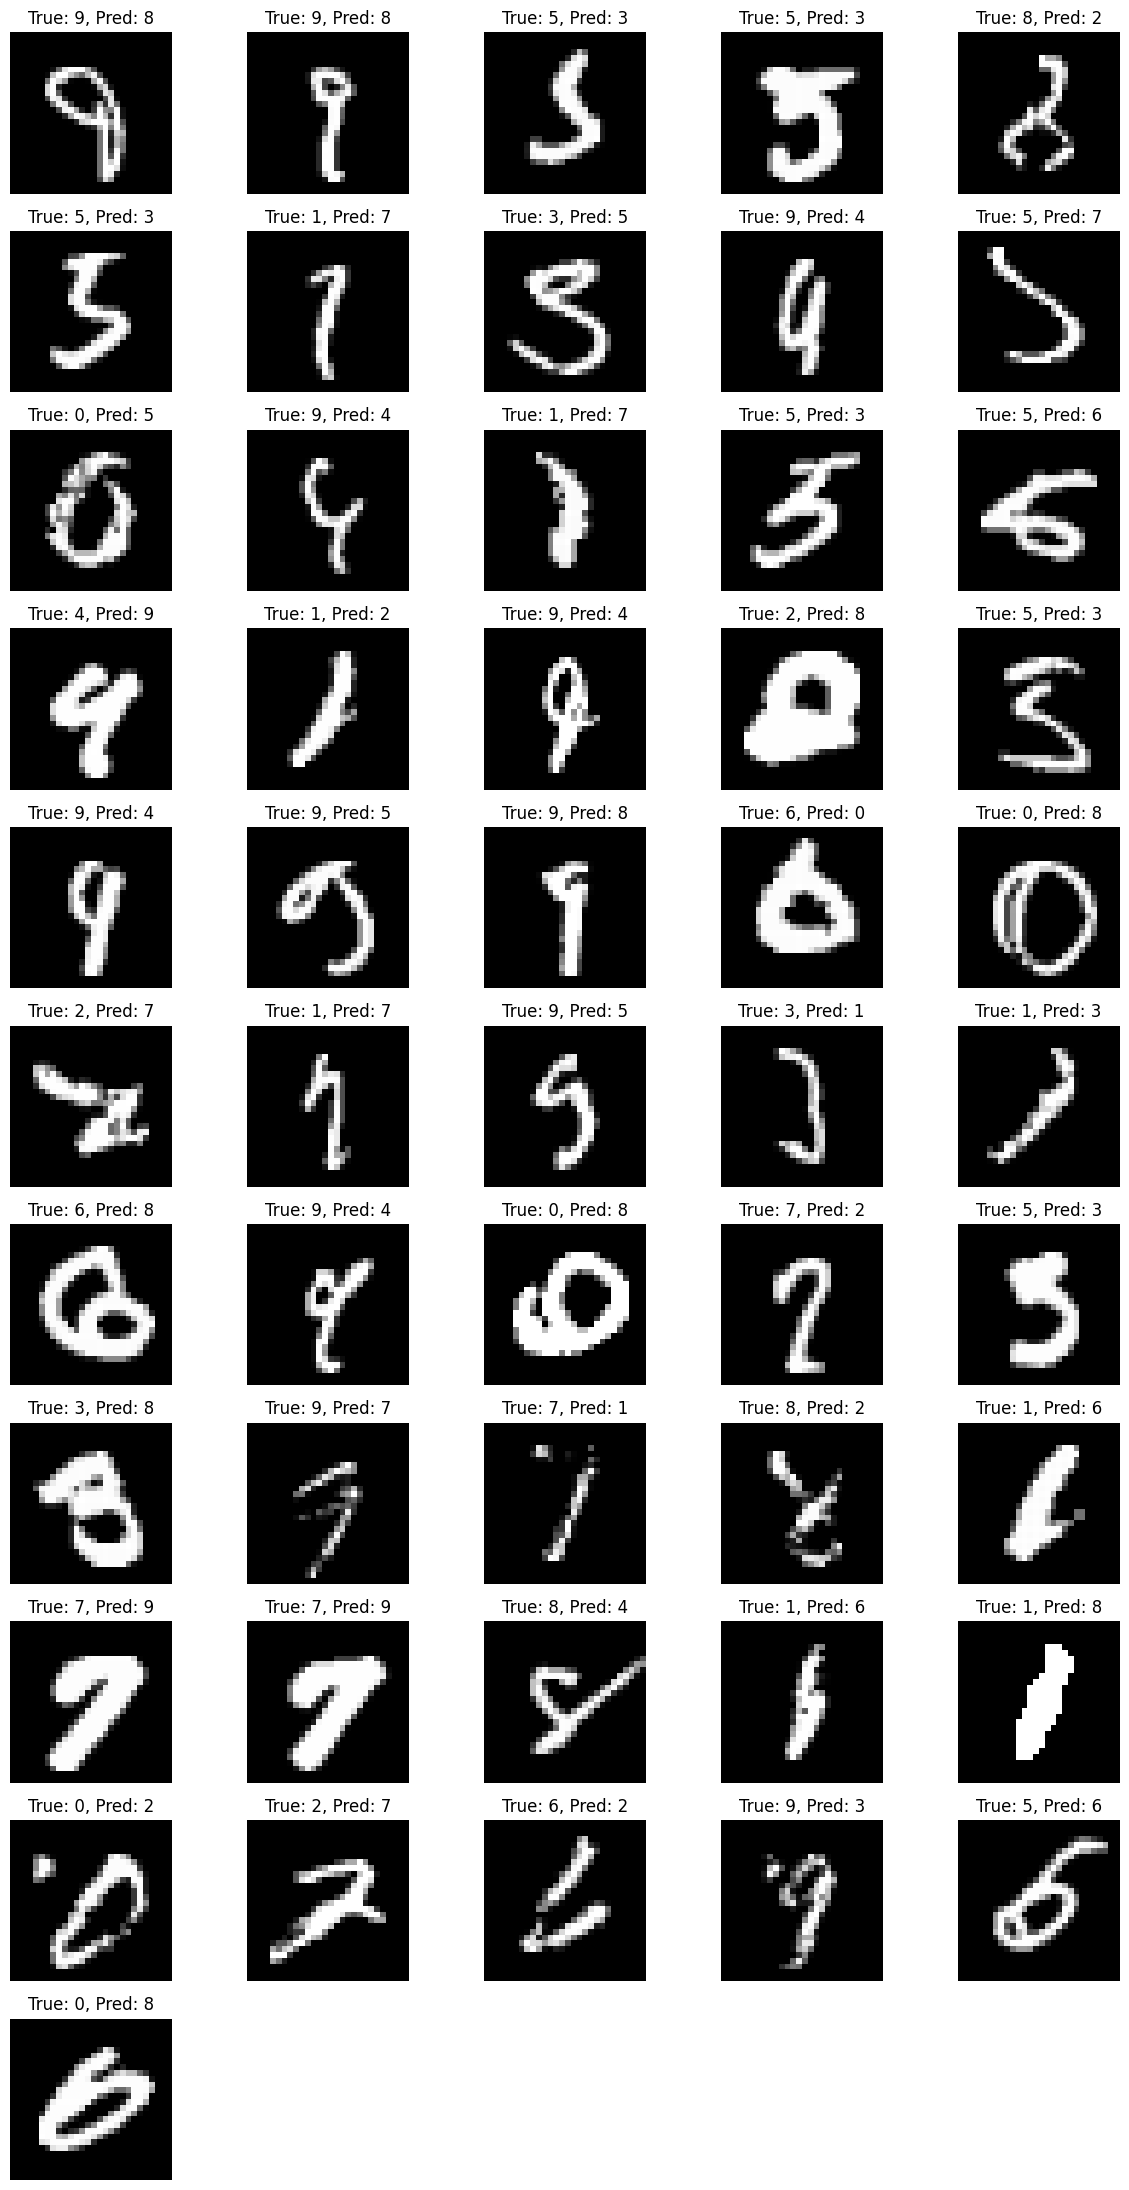

In [53]:
# evaluate misclassified images
misclassified = np.where(y_pred != y_true)[0]
num_miscl = len(misclassified)
print(f"Misclassified = {num_miscl}")

remainder = num_miscl%5
rows = int(((num_miscl - remainder)/5) + remainder)

plt.figure(figsize=(12, rows*2))
for i, idx in enumerate(misclassified[:num_miscl]):
    plt.subplot(rows, 5, i + 1)
    plt.imshow(test_X[idx].squeeze(), cmap='gray')
    plt.title(f"True: {y_true[idx]}, Pred: {y_pred[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()